In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# Load Data and Inspect
inputTrip = "TripA01"
dataTrip1 = pd.read_csv(f"{inputTrip}.csv", sep=";", encoding='unicode_escape')
dfTrip1 = pd.DataFrame(dataTrip1)

# Conforming Datasets
def conform_datasets(nbOfTrips, pathToFiles, col_list=None):
    dfSummerTrips = []
    if not col_list:
        col_list = []
    inputTripsA = pathToFiles
    for i in range(0, nbOfTrips):
        dataTrip = pd.read_csv(f"{inputTripsA}{(i+1):02}.csv", sep=";", encoding='unicode_escape') 
        dfSummerTrips.append(pd.DataFrame(dataTrip))
        if not col_list: 
            col_list = dfSummerTrips[i].columns.tolist()
        elif set(col_list) != set(dfSummerTrips[i].columns.tolist()):
            diff = list(set(col_list) - set(dfSummerTrips[i].columns.tolist()))
            for item in diff:
                col_list.remove(item)
    
    for i, trip in enumerate(dfSummerTrips):
        dfSummerTrips[i] = trip[col_list]
    return dfSummerTrips, col_list

pathA = "TripA"
dfSummerTrips, consistent_cols = conform_datasets(nbOfTrips=32, pathToFiles=pathA)

# Feature Engineering
def prepare_features(df_TripList, stepWidth, dropNan=False):
    newfeatures = []
    for i, trip_df in enumerate(df_TripList):
        if dropNan:
            trip_df = trip_df.dropna()
            trip_df.index = range(len(trip_df))

        dfLength = len(trip_df.index)
        numRows  = dfLength // stepWidth
        for i in range(0, numRows):
            averageVals = trip_df.iloc[i*stepWidth:(i+1)*stepWidth].sum() 
            averageVals = averageVals / (1. * stepWidth)
            featureList = averageVals.add_prefix('avrg_')
            elevationDiff = trip_df.loc[(i+1)*stepWidth, 'Elevation [m]'] - trip_df.loc[i*stepWidth, 'Elevation [m]']
            featureList['Elevation change'] = elevationDiff 
            featuresAtBeginningOfWindow = trip_df.loc[i*stepWidth, ['SoC [%]', 'displayed SoC [%]']] 
            featureList["Previous SoC"] = featuresAtBeginningOfWindow['SoC [%]']
            featureList["Previous displayed SoC"] = featuresAtBeginningOfWindow['displayed SoC [%]']
            featuresAtEndOfWindow = trip_df.loc[(i+1)*stepWidth, ['SoC [%]', 'displayed SoC [%]']] 
            featureList["Next SoC"] = featuresAtEndOfWindow['SoC [%]']
            featureList["Next displayed SoC"] = featuresAtEndOfWindow['displayed SoC [%]']
            newfeatures.append(featureList)    
    
    newDf = pd.DataFrame(newfeatures)
    newDf = newDf.drop(columns=['avrg_SoC [%]', 'avrg_displayed SoC [%]', 'avrg_Time [s]', 'avrg_Elevation [m]'])
    hasNaN = newDf.isnull().values.any()
    return newDf

newDf = prepare_features(dfSummerTrips, stepWidth=60)

# Split and Normalize the features
def split_TestTrain(df, scaler=None):
    try:
        X = df.drop(columns=['Next SoC', 'Previous displayed SoC', 'Next displayed SoC'])
    except:
        X = df
    y = df['Next SoC'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if not scaler:
        scaler = StandardScaler().fit(X)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    return scaler, [X_train_scaled, y_train, X_train.index], [X_test_scaled, y_test, X_test.index]

scalerSummerTrips, train_tuple, test_tuple = split_TestTrain(newDf)
X_train_scaled, y_train, index_train = train_tuple
X_test_scaled,  y_test,  index_test  = test_tuple

def fit_model_RandomForest(X, Y, X_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, Y)
    y_pred = model.predict(X_test)
    return y_pred, model

# Train and Evaluate Models
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    
# Random Forest
y_pred_rf, model_rf = fit_model_RandomForest(X_train_scaled, y_train, X_test_scaled)
print("Random Forest Model:")
evaluate_model(y_test, y_pred_rf)
from sklearn.metrics import r2_score

# Calculate R-squared for Random Forest
r2_rf = r2_score(y_test, y_pred_rf)
print("R-squared for Random Forest:", r2_rf)

Random Forest Model:
Mean Squared Error: 0.004652291380099839
Mean Absolute Error: 0.04646677480719781
R-squared for Random Forest: 0.9999553822394168


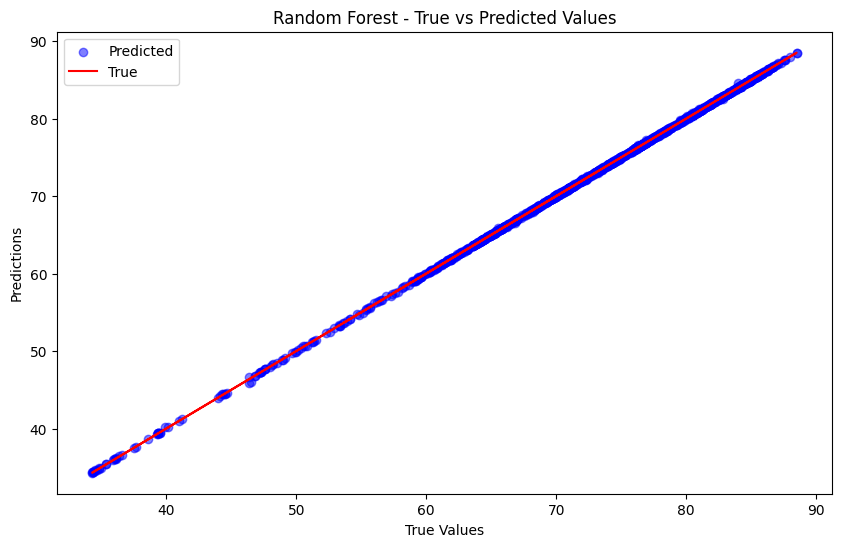

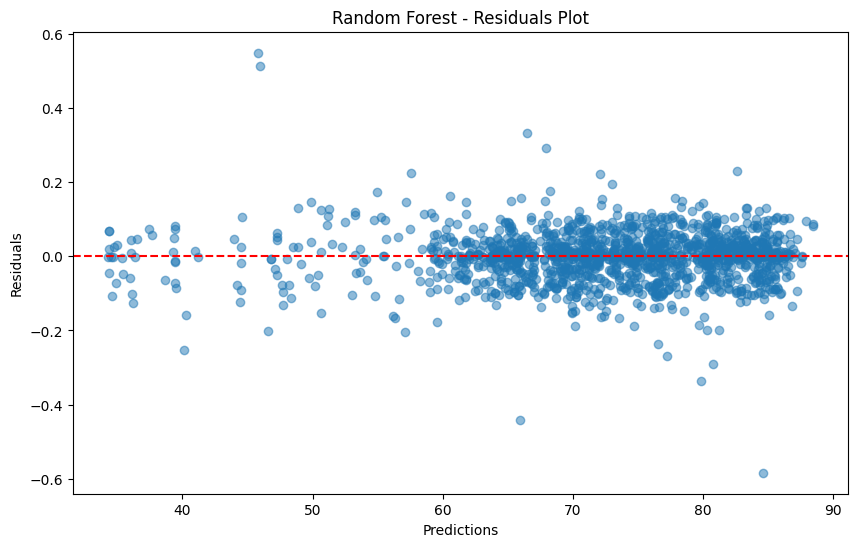

In [2]:
def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted', color='blue')
    plt.plot(y_true, y_true, color='red', label='True')
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{model_name} - True vs Predicted Values")
    plt.legend()
    plt.show()

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} - Residuals Plot")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

plot_results(y_test, y_pred_rf, "Random Forest")
plot_residuals(y_test, y_pred_rf, "Random Forest")

In [3]:
# Predicting Battery Capacity
battery_capacity_predictions = y_pred_rf
battery_capacity= np.mean(battery_capacity_predictions)

# Predicting Energy Consumption Rate
energy_consumption_rate = (newDf['Next SoC'] - newDf['Previous SoC']) / 0.1

# Calculate the energy consumption rate for each prediction of battery capacity
energy_consumption_rate_pred = np.diff(battery_capacity_predictions) / 0.1
energy_consumption_rate = np.mean(energy_consumption_rate_pred)

# Calculate remaining driving time
def calculate_remaining_driving_time(predicted_soc, battery_capacity_wh, energy_consumption_rate_w):
    remaining_energy_kwh = predicted_soc / 100 * battery_capacity_wh
    remaining_driving_time_min = remaining_energy_kwh / energy_consumption_rate_w
    remaining_driving_time_hr = remaining_driving_time_min/60
    return remaining_driving_time_hr, remaining_driving_time_min

# Calculate remaining driving time for a given State of Charge (SoC)
soc = 100  # Specify the desired SoC
hour, mins = calculate_remaining_driving_time(soc, battery_capacity, energy_consumption_rate)
print(f"Driving time left for SoC {soc}%: {hour} hours OR {mins} mins")

Driving time left for SoC 100%: 9.739624153631798 hours OR 584.3774492179078 mins
